In [1]:
import librosa
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy
from scipy.io import wavfile
import scipy.fftpack as fft
from scipy.signal import get_window
import IPython.display as ipd
import matplotlib.pyplot as plt
%matplotlib inline
import os
import csv

# Preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score
#Keras
#import tensorflow as tf
import keras
#from keras.callbacks import ModelCheckpoint
#import eli5
#from eli5.sklearn import PermutationImportance
from keras import models
from keras import layers
from keras.models import Sequential       
from keras.layers.core import Dense
from keras.wrappers.scikit_learn import KerasClassifier

Using TensorFlow backend.


In [3]:
header = 'filename chroma_stft rmse spectral_centroid spectral_bandwidth rolloff zero_crossing_rate'
for i in range(1, 21):
    header += f' .mfcc{i}'
header += ' label'
header = header.split()

In [4]:
file = open('data.csv', 'w', newline='')
label1='covid'
label2='healthy'
with file:
    writer = csv.writer(file)
    writer.writerow(header)
some_files = range(1,141)
map(str,some_files)
for m in some_files:
    
    if (m==29 or m==124):
            continue
            
    for filename in os.listdir(f'{m}'):
        cough_sample = f'{m}/{filename}'
        y, sr = librosa.load(cough_sample)
        #audio features extracted using librosa
        chroma_stft = librosa.feature.chroma_stft(y=y, sr=sr)
        rms = librosa.feature.rms(y=y)
        spec_cent = librosa.feature.spectral_centroid(y=y, sr=sr)
        spec_bw = librosa.feature.spectral_bandwidth(y=y, sr=sr)
        rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr)
        zcr = librosa.feature.zero_crossing_rate(y)
        mfcc = librosa.feature.mfcc(y=y, sr=sr)
        to_append = f'{filename} {np.mean(chroma_stft)} {np.mean(rms)} {np.mean(spec_cent)} {np.mean(spec_bw)} {np.mean(rolloff)} {np.mean(zcr)}'    
        for e in mfcc:
            to_append += f' {np.mean(e)}'
        if (m<71):
            to_append += f' {label1}'
        else:
            to_append += f' {label2}'
        file = open('data.csv', 'a', newline='')
        with file:
            writer = csv.writer(file)
            writer.writerow(to_append.split())

In [2]:
data = pd.read_csv('data.csv')
data.head()

,filename,chroma_stft,rmse,spectral_centroid,spectral_bandwidth,rolloff,zero_crossing_rate,.mfcc1,.mfcc2,.mfcc3,...,.mfcc12,.mfcc13,.mfcc14,.mfcc15,.mfcc16,.mfcc17,.mfcc18,.mfcc19,.mfcc20,label
0,cough-shallow.wav,0.365870,0.004746,2611.112354,2107.843369,5006.072801,0.213307,-588.241516,56.374695,-23.335653,...,-22.707611,-7.822541,7.475875,22.179073,-5.627593,-0.637800,-11.179053,-4.950185,-9.120401,covid
1,cough-shallow.wav,0.335586,0.033097,2447.120001,1910.796810,4485.971832,0.250860,-440.529205,47.488827,7.410370,...,-3.478875,-13.854512,-7.112824,1.634259,-2.702559,3.150217,-3.079507,-7.185557,-3.072667,covid
2,cough-shallow.wav,0.328111,0.102448,1887.798005,1748.314420,3866.007487,0.139323,-215.404968,111.668701,-26.653772,...,-11.986691,-0.444713,-7.749365,2.854637,-13.276996,-1.203972,-13.691702,-2.701706,0.212865,covid
3,cough-shallow.wav,0.401336,0.022822,2912.035850,2282.839904,5562.184969,0.284299,-493.786621,32.383282,-16.463573,...,-2.592430,-2.959467,-0.938979,-3.011075,-6.139257,-1.814536,-5.921026,-0.590423,-1.423850,covid
4,cough-shallow.wav,0.343985,0.064780,1760.547753,1229.892286,2927.621794,0.147492,-334.880096,76.660675,-61.654518,...,-2.217887,-4.896855,-11.936958,-5.554993,-12.191449,-6.108358,-4.835579,-6.486970,-10.175231,covid


In [3]:
# Dropping unneccesary columns
data = data.drop(['filename'],axis=1)
data.head()

,chroma_stft,rmse,spectral_centroid,spectral_bandwidth,rolloff,zero_crossing_rate,.mfcc1,.mfcc2,.mfcc3,.mfcc4,...,.mfcc12,.mfcc13,.mfcc14,.mfcc15,.mfcc16,.mfcc17,.mfcc18,.mfcc19,.mfcc20,label
0,0.365870,0.004746,2611.112354,2107.843369,5006.072801,0.213307,-588.241516,56.374695,-23.335653,0.607189,...,-22.707611,-7.822541,7.475875,22.179073,-5.627593,-0.637800,-11.179053,-4.950185,-9.120401,covid
1,0.335586,0.033097,2447.120001,1910.796810,4485.971832,0.250860,-440.529205,47.488827,7.410370,19.503265,...,-3.478875,-13.854512,-7.112824,1.634259,-2.702559,3.150217,-3.079507,-7.185557,-3.072667,covid
2,0.328111,0.102448,1887.798005,1748.314420,3866.007487,0.139323,-215.404968,111.668701,-26.653772,41.542076,...,-11.986691,-0.444713,-7.749365,2.854637,-13.276996,-1.203972,-13.691702,-2.701706,0.212865,covid
3,0.401336,0.022822,2912.035850,2282.839904,5562.184969,0.284299,-493.786621,32.383282,-16.463573,11.529562,...,-2.592430,-2.959467,-0.938979,-3.011075,-6.139257,-1.814536,-5.921026,-0.590423,-1.423850,covid
4,0.343985,0.064780,1760.547753,1229.892286,2927.621794,0.147492,-334.880096,76.660675,-61.654518,10.375974,...,-2.217887,-4.896855,-11.936958,-5.554993,-12.191449,-6.108358,-4.835579,-6.486970,-10.175231,covid


In [4]:
coughs = data.iloc[:, -1]
#label encoding
encoder = LabelEncoder()
y = encoder.fit_transform(coughs)

In [5]:
#scaling th input data
scaler = StandardScaler()
X = scaler.fit_transform(np.array(data.iloc[:, :-1], dtype = float))

In [14]:
#train-test-split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [22]:
#we use this split for ANN
X_testmod,X_val,y_testmod,y_val=train_test_split(X_test,y_test,test_size=0.5,random_state=0)


#initialise the ANN, defines ANN as sequence of layers
model = models.Sequential()
#we will add the input layer and the 1st hidden layer
#here the .add adds different layers
#the first parameter specifies the number of nodes in the hidden layer. It is generally calculated as the average(number of input layers+number of output layers) 
#the rectifier function is used as the activation function for the hidden layer 
model.add(layers.Dense(14, activation='relu', input_shape=(X_train.shape[1],)))
#we will add another hidden layer 
#model.add(layers.Dense(14, activation='relu'))
#add the output layer
#output_dim=outcome for the output layer. Here it is set to 1 because the outcome is binary, i.e., covid or healthy
#the activation function used on the output layer is sigmoid. This is to get the probability of the outcome
model.add(layers.Dense(1, activation='sigmoid'))

In [23]:
#compile the ANN
#we will use Stochastic Gradient Descent to the entire ANN to find the optimal set of weights. There are many types of descent. we have used 'adam' algorithm as our stochastic gradient descent. 
#this 'adam' algorithm is based on loss function. For example, in simple linear regression the loss function is the sum of the difference between the real value and predicted value. For stochastic gradient descent, the the loss function is the logarithmic loss  
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [24]:
#Fit ANN to the training set
#NOTE: there is no standard rule to select batch_size or epochs. Generally the batch_size=10 and epochs=100
history = model.fit(X_train,
                    y_train,
                    epochs=40,
                    batch_size=20, validation_data=(X_val,y_val) )

Train on 96 samples, validate on 21 samples
Epoch 1/40
96/96 [==============================] - 0s 4ms/step - loss: 0.7711 - accuracy: 0.4896 - val_loss: 0.7442 - val_accuracy: 0.5714
Epoch 2/40
96/96 [==============================] - 0s 94us/step - loss: 0.7546 - accuracy: 0.4792 - val_loss: 0.7319 - val_accuracy: 0.5714
Epoch 3/40
96/96 [==============================] - 0s 104us/step - loss: 0.7391 - accuracy: 0.4792 - val_loss: 0.7206 - val_accuracy: 0.5714
Epoch 4/40
96/96 [==============================] - 0s 104us/step - loss: 0.7264 - accuracy: 0.4792 - val_loss: 0.7106 - val_accuracy: 0.5714
Epoch 5/40
96/96 [==============================] - 0s 115us/step - loss: 0.7146 - accuracy: 0.4896 - val_loss: 0.7016 - val_accuracy: 0.5714
Epoch 6/40
96/96 [==============================] - 0s 115us/step - loss: 0.7043 - accuracy: 0.4792 - val_loss: 0.6928 - val_accuracy: 0.5714
Epoch 7/40
96/96 [==============================] - 0s 94us/step - loss: 0.6919 - accuracy: 0.4792 - val_lo

In [25]:
test_loss, test_acc = model.evaluate(X_testmod,y_testmod)
print('test_acc:, test_loss',test_acc, test_loss)

21/21 [==============================] - 0s 48us/step
test_acc:, test_loss 0.6190476417541504 0.7426185011863708


In [26]:
#predict the test set result
#predictions shows the probability of the outcome being covid or healthy
predictions = model.predict(X_testmod)
#it means that if predictions >0.5, the subject is healthy. Else he is a covid patient
#we get the predictions output as true and false
predictions=(predictions>0.5)
#the predictions values are converted to 0 and 1
predictions = np.multiply(predictions, 1)
#implement the confusion matrix
cm=confusion_matrix(y_testmod,predictions)
auc = roc_auc_score(y_testmod, predictions)

In [27]:
print("\n area under the curve=",auc)
print("\n confusion matrix is\n", cm)


 area under the curve= 0.5961538461538461

 confusion matrix is
 [[4 4]
 [4 9]]


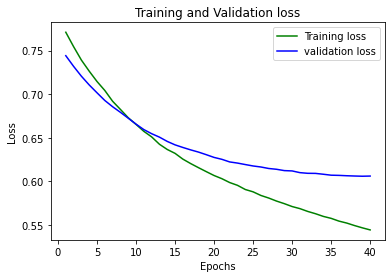

In [28]:
#Visualizing train and validation loss
loss_train = history.history['loss']
loss_val = history.history['val_loss']
loss_train=np.array(loss_train)
loss_val=np.array(loss_val)
epochs = range(1,41)
epochs=np.array(epochs)
plt.plot(epochs, loss_train, 'g', label='Training loss')
plt.plot(epochs, loss_val, 'b', label='validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

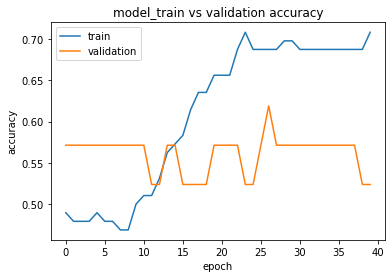

In [29]:
#Visualizing train and validation accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
epoch=range(1,41)
plt.title('model_train vs validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','validation'],loc='upper left')
plt.show()

In [15]:
#try SVM with scikit learn
from sklearn.svm import SVC
classifier = SVC(kernel = 'linear', random_state = 0)
classifier.fit(X_train, y_train)
y_pred=classifier.predict(X_test)
cm=confusion_matrix(y_test,y_pred)
acc=accuracy_score(y_pred,y_test)
auc = roc_auc_score(y_test, y_pred)

TP = cm[0][0]
FN = cm[0][1]
FP = cm[1][0]
TN = cm[1][1]

# Sensitivity, hit rate, recall, or true positive rate
TPR = TP/(TP+FN)
# Specificity or true negative rate
TNR = TN/(TN+FP)

#applying 5 cross validation
accuracies=cross_val_score(estimator=classifier,X=X_train, y=y_train, cv=5)
c=accuracies.mean()
d=accuracies.std()

In [16]:
print("mean of accuracies=",c,"\n mean of variance=",d,"\n accuracy=",acc,"\n sensitivity=",TPR,"\n specificity=",TNR,"\n area under the curve=",auc)
print("\n confusion matrix is\n", cm)

mean of accuracies= 0.4473684210526315 
 mean of variance= 0.04707511531578505 
 accuracy= 0.5952380952380952 
 sensitivity= 0.6842105263157895 
 specificity= 0.5217391304347826 
 area under the curve= 0.602974828375286

 confusion matrix is
 [[13  6]
 [11 12]]


In [17]:
#try logistic regression with scikit learn
from sklearn.linear_model import LogisticRegression
classifier=LogisticRegression()
classifier.fit(X_train, y_train)
y_pred=classifier.predict(X_test)
cm=confusion_matrix(y_test,y_pred)
acc=accuracy_score(y_pred,y_test)
auc = roc_auc_score(y_test, y_pred)

TP = cm[0][0]
FN = cm[0][1]
FP = cm[1][0]
TN = cm[1][1]

# Sensitivity, hit rate, recall, or true positive rate
TPR = TP/(TP+FN)
# Specificity or true negative rate
TNR = TN/(TN+FP)

#applying 5 cross validation
accuracies=cross_val_score(estimator=classifier,X=X_train, y=y_train, cv=5)
c=accuracies.mean()
d=accuracies.std()

In [18]:
print("mean of accuracies=",c,"\n mean of variance=",d,"\n accuracy=",acc,"\n sensitivity=",TPR,"\n specificity=",TNR,"\n area under the curve=",auc)
print("\n confusion matrix is\n", cm)

mean of accuracies= 0.46842105263157896 
 mean of variance= 0.12275688199674319 
 accuracy= 0.5952380952380952 
 sensitivity= 0.6842105263157895 
 specificity= 0.5217391304347826 
 area under the curve= 0.602974828375286

 confusion matrix is
 [[13  6]
 [11 12]]


In [19]:
#try naive bayes with scikit learn
from sklearn.naive_bayes import GaussianNB
classifier = GaussianNB()
classifier.fit(X_train, y_train)
y_pred=classifier.predict(X_test)
cm=confusion_matrix(y_test,y_pred)
acc=accuracy_score(y_pred,y_test)
auc = roc_auc_score(y_test, y_pred)

TP = cm[0][0]
FN = cm[0][1]
FP = cm[1][0]
TN = cm[1][1]

# Sensitivity, hit rate, recall, or true positive rate
TPR = TP/(TP+FN)
# Specificity or true negative rate
TNR = TN/(TN+FP)

#applying 5 cross validation
accuracies=cross_val_score(estimator=classifier,X=X_train, y=y_train, cv=5)
c=accuracies.mean()
d=accuracies.std()

In [21]:
print("mean of accuracies=",c,"\n mean of variance=",d,"\n accuracy=",acc,"\n sensitivity=",TPR,"\n specificity=",TNR,"\n area under the curve=",auc)
print("\n confusion matrix is\n", cm)

mean of accuracies= 0.45894736842105266 
 mean of variance= 0.10412010963265886 
 accuracy= 0.5714285714285714 
 sensitivity= 0.5789473684210527 
 specificity= 0.5652173913043478 
 area under the curve= 0.5720823798627002

 confusion matrix is
 [[11  8]
 [10 13]]
